<a href="https://colab.research.google.com/github/saiparsa/Machine-Learning-Signal-Processing-Applications/blob/master/Kernel_PCA_MFCC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import cv2
import librosa
import pandas as pd
import scipy
import cmath
import sys 
from sklearn.decomposition import PCA
import IPython.display as ipd
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.io import wavfile

# MFCC

In [ ]:
file=[]
pc=librosa.load('Piano_Clap.wav',sr=16000)[0]

In [ ]:
ipd.display(ipd.Audio(pc, rate = 16000))

In [ ]:
mfcc=sio.loadmat('mfcc.mat')
mfcc=mfcc['X']
musigma=sio.loadmat('musigma.mat')
mX = musigma['mX']
sigma = musigma['Sigma']

pdf1 = multivariate_normal.pdf(mfcc.T,mX[:,0],sigma[:,:,0])
pdf2 = multivariate_normal.pdf(mfcc.T,mX[:,-1],sigma[:,:,-1])
pdf1=pdf1.reshape(-1,1)
pdf2=pdf2.reshape(-1,1)
p=np.hstack((pdf1,pdf2))
pdf_den = np.sum(p,axis=1)
pdf_den=pdf_den.reshape(-1,1)
pdf = p/pdf_den

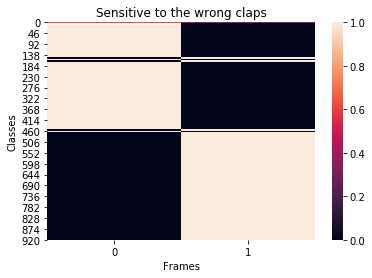

In [ ]:
sns.heatmap(pdf)
plt.title("Sensitive to the wrong claps")
plt.ylabel('Classes')
plt.xlabel('Frames')

plt.show()

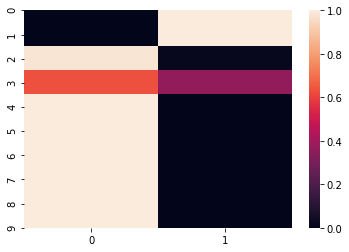

In [ ]:
sns.heatmap(pdf[0:10][:]) # This is the reason why naive smoothing fails and we need to implement viterbi
plt.show()

In [ ]:
T = np.asarray([[0.9,0.1],[0,1]])
pdf=pdf.T
P = np.zeros((2, 962))
P[:,0] = pdf[:,0]

for t in range(pdf.shape[1]-1):
    
    b = np.argmax(P[:,t]) 
    P[:,t+1] = np.multiply(T[b,:].T,pdf[:,t+1])
    
    den = P[0,t+1]+P[1,t+1]
    P[0,t+1] = P[0,t+1]/den
    P[1,t+1] = P[1,t+1]/den
   
  

(2, 962)

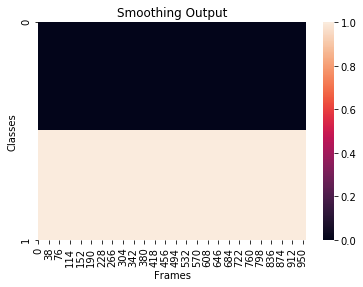

In [ ]:
sns.heatmap(P)
plt.title("Smoothing Output")
plt.ylabel('Classes')
plt.xlabel('Frames')

plt.show()

I don't think this smoothing makes any sense, it has worsen the situation.

In [ ]:
P[:,0] = pdf[:,0]
B = np.zeros((2, 962))
p=p.T
for t in range(pdf.shape[1]-1):
    
    d = P[0,t]+P[1,t]
    P[0,t] = P[0,t]/d
    P[1,t] = P[1,t]/d 
        
    b0 = np.argmax(T[:,0]*P[:,t])
    b1 = np.argmax(T[:,1]*P[:,t])
    #print(b0,b1)
    B[0][t+1] = b0
    B[1][t+1] = b1
    
    P[0][t+1] = T[b0][0]*P[b0][t]*p[0][t+1]
    P[1][t+1] = T[b1][1]*P[b1][t]*p[1][t+1]
    
    den = P[0,t+1]+P[1,t+1]
    P[0,t+1] = P[0,t+1]/den
    P[1,t+1] = P[1,t+1]/den    
    
 V = np.zeros((2,962))
prev = np.argmax(P[:,961])
V[prev,961]=1
for t in range(pdf.shape[1]-1,-1,-1):
    
    prev=int(B[prev,t])
    V[prev,t-1]=1
    
    
    
    

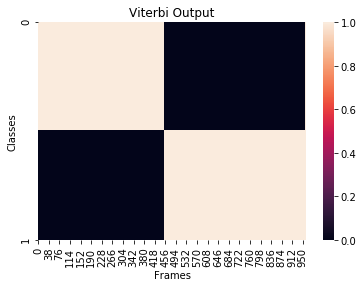

In [ ]:
sns.heatmap(V)
plt.title("Viterbi Output")
plt.ylabel('Classes')
plt.xlabel('Frames')

plt.show()

# Multi Dimensional Scaling

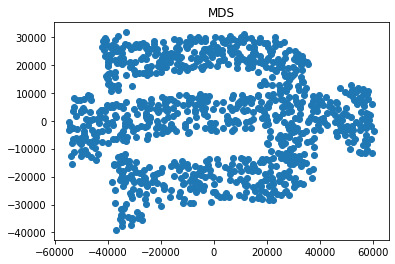

In [ ]:
data=sio.loadmat('MDS_pdist.mat')
L=data['L']
L_n=L-np.mean(L,axis=0)
L_f=L_n - np.mean(L_n,axis=1)
Y= L_f-np.mean(L_f)
W=np.dot(Y.T,Y)
W = W/(-2)
u, v, x = np.linalg.svd(W, full_matrices=True)
c=np.dot(u,np.sqrt(np.diag(v)))

plt.scatter(x=c[:,0],y=c[:,1])
plt.title('MDS')
plt.show()

# Kernel PCA

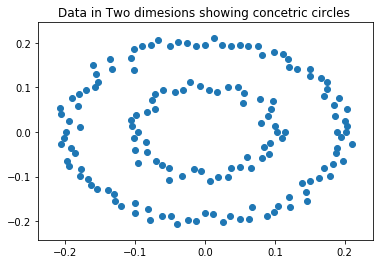

In [ ]:
data=sio.loadmat('concentric.mat')
X=data['X']
#X=np.asarray(X)
X.reshape(-1,1)
plt.scatter(X[0][:],X[1][:])
plt.title('Data in Two dimesions showing concetric circles ')
plt.show()

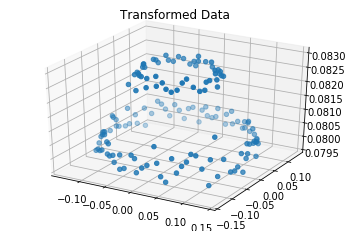

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#transforming data into higher dimension using Kernel trick
m,n = X.shape

D = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        
        D[i,j] = np.linalg.norm(X[:,i]-X[:,j])**2
        D[j,i] = D[i,j]


k = np.exp(-D)
k = np.linalg.eigh(k)[1]
data=k[:,149:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[:,0],data[:,1],data[:,2])
plt.title("Transformed Data")
plt.show()

In [ ]:
def sigmoid(s): #activation function
    return 1/(1 + np.exp(-s))
    
def sigmoid_derivative(s):
    return s * (1 - s)

def cost(pred, real):
    return(np.sum(1/2*(pred-real)**2))

def predict(X,params):
    y_pred=feed_forward_network_(X.T, params)[0]
    y_pred=y_pred.T
    for i in range(y_pred.shape[0]):
        if y_pred[i]>0.5:
            y_pred[i]=1
        else:
            y_pred[i]=0
    return y_pred

def accuracy(y,y_pred):
    acc=0
    for i in range(y.shape[0]):
        
        if y[i]==y_pred[i]:
            acc=acc+1
    return (acc/y.shape[0])*100

In [ ]:
def set_parameters_(x,y):
    
    input_size = x.shape[1]
    output_size = y.shape[1]
    w1 = np.random.randn(output_size, input_size)
    b1 = np.zeros((output_size, 1))
    
    return {'w1': w1, 'b1': b1}

In [ ]:
def feed_forward_network_(x, params):
    z1 = np.dot(params['w1'], x.T)+params['b1']
    y = sigmoid(z1)
  
    return y, {'z1': z1, 'y': y}

In [ ]:


def back_propagation_(x, y, params, cache,y_pred):
   
    loss = cost(y_pred.T,y)
    error = cache['y'] - y.T
    error_delta = error * sigmoid_derivative(cache['y'])  
    dw1 = error_delta.dot(x)
    db1 = np.sum(error, axis=1, keepdims=True)
    return {"dw1": dw1, "db1": db1},loss

In [ ]:
def update_parameter_(gradients,params, learning_rate):
    w1 = params['w1'] - learning_rate * gradients['dw1']
    b1 = params['b1'] - learning_rate * gradients['db1']

    return {'w1': w1, 'b1': b1}

In [ ]:
def build_neural_network_(x,y):
    params = set_parameters_(x,y)
    loss = {}
    for i in range(300000):
        op,op_cache = feed_forward_network_(x,params)
        gradients,loss[i] = back_propagation_(x,y,params,op_cache,op)
        params = update_parameter_(gradients,params,.05)
    lists = sorted(loss.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(x,y)
    plt.title('cost vs epochs')
    plt.xlabel("epochs")
    plt.ylabel("cost")
    plt.show()
    return params

In [ ]:
import pandas as pd
y=51*[0]+101*[1]
y=np.asarray(y)
y=y.reshape(-1,1)

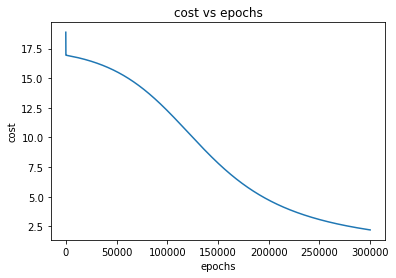

In [ ]:
params=build_neural_network_(data,y)



In [ ]:
y_pred=predict(data.T, params)

In [ ]:
accuracy(y,y_pred)

100.0

# NN vs Kernel PCA

In [ ]:
def set_parameters(x,y,hidden_size):
    
    input_size = x.shape[1]
    output_size = y.shape[1]
    w1 = np.random.randn(hidden_size, input_size)
    b1 = np.zeros((hidden_size, 1))
    w2 = np.random.randn(output_size, hidden_size)
    b2 = np.zeros((output_size, 1))
    return {'w1': w1, 'w2': w2, 'b1': b1, 'b2': b2}


In [ ]:
def feed_forward_network(x, params):
    z1 = np.dot(params['w1'], x.T)+params['b1']
  #print(z1)
    a1 = sigmoid(z1)
  #print(a1)
    z2 = np.dot(params['w2'], a1)+params['b2']
  #print(z2)
    y = sigmoid(z2)  
  #print(y)
    return y, {'z1': z1, 'z2': z2, 'a1': a1, 'y': y}

In [ ]:


def back_propagation(x, y, params, cache,y_pred):
   
    loss = cost(y_pred.T,y)
    #print(loss)
    #print('Error :', loss)
    error = cache['y'] - y.T
    error_delta = error * sigmoid_derivative(cache['y'])  
    dw2 = error_delta.dot(cache['a1'].T)
    db2 = np.sum(error, axis=1, keepdims=True)
    z2_error = error_delta.T.dot(params['w2'])
    z2_delta = z2_error.T * sigmoid_derivative(cache['a1'])
    dw1 = z2_delta.dot(x)
    db1 = np.sum(z2_delta, axis=1, keepdims=True)

    return {"dw1": dw1, "db1": db1, "dw2": dw2, "db2": db2},loss

In [ ]:
def update_parameters(gradients,params, learning_rate):
    w1 = params['w1'] - learning_rate * gradients['dw1']
    b1 = params['b1'] - learning_rate * gradients['db1']
    w2 = params['w2'] - learning_rate * gradients['dw2']
    b2 = params['b2'] - learning_rate * gradients['db2']
    return {'w1': w1, 'w2': w2, 'b1': b1, 'b2': b2}

In [ ]:
def build_neural_network(x,y):
    params = set_parameters(x,y,3)
    loss = {}
    for i in range(50000):
        op,op_cache = feed_forward_network(x,params)
        gradients,loss[i] = back_propagation(x,y,params,op_cache,op)
        params = update_parameters(gradients,params,0.01)
    lists = sorted(loss.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(x,y)
    plt.show()
    #print(loss)
    return params

In [ ]:
def predict(X,params):
    y_pred=feed_forward_network(X.T, params)[0]
    y_pred=y_pred.T
    for i in range(y_pred.shape[0]):
        if y_pred[i]>0.5:
            y_pred[i]=1
        else:
            y_pred[i]=0
    return y_pred
    

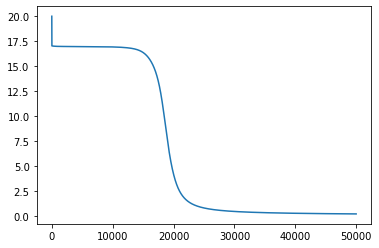

In [ ]:
params=build_neural_network(X.T,y) # on data without kernel pca

In [ ]:
y_pred=predict(X, params)

In [ ]:
accuracy(y,y_pred)

100.0